## 1. Downloading the data

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import shutil
import warnings
import pandas as pd
import time
import random

import tensorflow as tf

from google.colab import drive, files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define the dataset implemented
GDRIVE_DATASET_FOLDER_NAME = "final_dataset.zip"

LOCAL_DATASET_PATH = "/content/dataset"
if os.path.exists(LOCAL_DATASET_PATH):
  shutil.rmtree(LOCAL_DATASET_PATH)

# Download the dataset
!unzip -qn "$GDRIVE_DATASET_PATH" -d "$LOCAL_DATASET_PATH" > /dev/null

for folder in glob(LOCAL_DATASET_PATH+"/*"):
  for in_folder in glob(folder+"/*"):
    file_name = in_folder.split("/")[4]
    shutil.move(in_folder,os.path.join(LOCAL_DATASET_PATH, file_name))

  shutil.rmtree(folder)

In [ ]:
dataset = pd.read_csv(os.path.join(LOCAL_DATASET_PATH, "dataset.csv"), index_col=[0])

dataset

,person_id,age,complexion,genere,observation,nir_image,preprocessed_image,mask,acf_bbox_x1,acf_bbox_x2,acf_bbox_y1,acf_bbox_y2,acf_center_x,acf_center_y,arm_angle
0,M0001,11,obese,M,NaN,nir_images/0.png,preprocessed_images/0.png,masks/0.png,779,1126,346,672,953,509,5.0
1,M0002,11,skinny,F,NaN,nir_images/1.png,preprocessed_images/1.png,masks/1.png,837,1080,490,750,959,620,5.0
2,M0003,12,slim,F,NaN,nir_images/2.png,preprocessed_images/2.png,masks/2.png,893,1185,132,424,1039,278,168.0
3,M0004,12,slim,F,NaN,nir_images/3.png,preprocessed_images/3.png,masks/3.png,730,985,431,683,858,557,5.0
4,M0005,11,skinny,M,NaN,nir_images/4.png,preprocessed_images/4.png,masks/4.png,770,997,409,634,884,522,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,M1006,16,slim,F,NaN,nir_images/2011.png,preprocessed_images/2011.png,masks/2011.png,877,1070,302,493,974,398,177.0
2012,M1007,19,slim,M,NaN,nir_images/2012.png,preprocessed_images/2012.png,masks/2012.png,655,869,433,656,762,545,11.0
2013,M1008,16,slim,M,NaN,nir_images/2013.png,preprocessed_images/2013.png,masks/2013.png,718,972,206,481,845,344,5.0
2014,M1009,16,slim,F,NaN,nir_images/2014.png,preprocessed_images/2014.png,masks/2014.png,850,1093,239,462,972,351,5.0


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 16

TOTAL_SAMPLES = len(dataset)
print("Total samples:", TOTAL_SAMPLES)

NUM_TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.70)
NUM_VAL_SAMPLES = int(TOTAL_SAMPLES * 0.20)
NUM_TEST_SAMPLES = int(TOTAL_SAMPLES * 0.10)

print("Number of train images:",NUM_TRAIN_SAMPLES," val images:",NUM_VAL_SAMPLES," test images:",NUM_TEST_SAMPLES)

def obtain_subset(dataset):
  images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
  masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
  x_centers = [ int(x) for x in dataset["acf_center_x"].values]
  y_centers = [ int(y) for y in dataset["acf_center_y"].values]
  angles = [ int(angle) for angle in dataset["arm_angle"].values]
  ids = [ int(id) for id in dataset.index]

  # Normalize angles and avoid similarity between 0 and 180
  for idx, angle in enumerate(angles):
    if angle > 170:
      angles[idx] = 0

  return images, masks, x_centers, y_centers, angles, ids

train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles, train_ids = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles, val_ids = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles, test_ids = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

Total samples: 2016
Number of train images: 1411  val images: 403  test images: 201


## 2. Model inference

In [ ]:
SAVED_MODEL = "/content/gdrive/Shareddrives/Vein Segmentation 💉/experiments/final/unet_multi"
unet = tf.keras.models.load_model(SAVED_MODEL)
unet

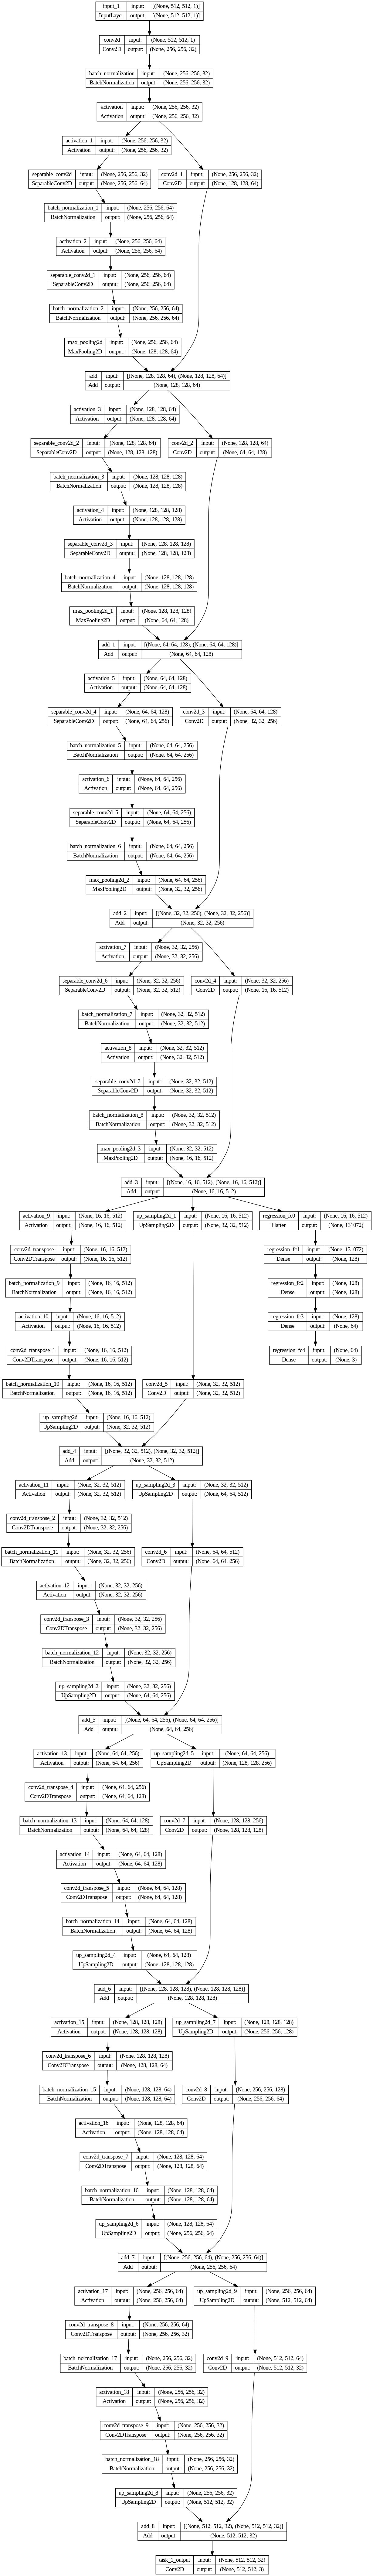

In [ ]:
tf.keras.utils.plot_model(unet, to_file="architecture.jpg", show_shapes=True)

In [ ]:
def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=1)
  base_image = image
  image.set_shape([None, None, 1])
  if mask:
    image = tf.cast(image, dtype=tf.int32)
    return image
  else:
    image = tf.cast(image, dtype=tf.float32)
    image = image / 127.5 - 1
    return image, base_image

def normalize(image):
  image = image[:, 540:1620]
  image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
  return image

def infer(model, image_tensor):
  mask, values = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  mask = np.squeeze(mask)
  mask_npy = np.argmax(mask, axis=2).astype(np.uint8)
  mask = tf.convert_to_tensor(mask_npy)

  predictions = {"image": image_tensor,
               "mask": mask,
               "x":int(values[0][0] * 1080) + 420,
               "y":int(values[0][1] * 1080),
               "angle":values[0][2] * 180,
               "type":"predicted"}

  return predictions


def plot_visualization(real_data, predicted_data):
  colors = {"background":[59, 82, 139],
            "arm":[3, 31, 254],
            "veins":[253, 231, 37]}

  visualization = []
  image = real_data["image"].numpy().astype(np.uint8)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  for data in [real_data,
               predicted_data
               ]:
    mask = data["mask"].numpy().astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    mask[np.where((mask==[0,0,0]).all(axis=2))] = colors["background"]
    mask[np.where((mask==[1,1,1]).all(axis=2))] = colors["arm"]
    mask[np.where((mask==[2,2,2]).all(axis=2))] = colors["veins"]

    if data["type"] == "predicted":
      mask = cv2.resize(mask, (1080,1080), interpolation = cv2.INTER_AREA)
      final_mask = np.full(shape = (1080,1920,3), fill_value=colors["background"])
      final_mask[:,540:1620,:] = mask
      mask = final_mask.astype(np.uint8)

    new_image = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    angle = data["angle"]
    cv2.circle(new_image, (data["x"], data["y"]), radius=10, color=(0,255,0), thickness=-1)
    cv2.putText(new_image, f"{angle:.2f}", (data["x"]+10,data["y"]+5), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), thickness = 5)
    visualization.append(new_image)

    # Preprocessing
    new_image2 = cv2.addWeighted(image, 0.8, mask, 0.5, 0.0)
    size = 100
    start_point = (data["x"]-int(size/2), data["y"]-int(size/2))
    end_point = (data["x"]+int(size/2), data["y"]+int(size/2))
    new_image2 = cv2.rectangle(new_image2, start_point, end_point, (0,255,0), 5)
    visualization.append(new_image2)
    cv2.imwrite(f"inference.jpg", cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

  f, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(12, 7))

  ax[0][0].set_title("Real")
  ax[0][0].imshow(visualization[0])
  ax[0][1].set_title("Predicted")
  ax[0][1].imshow(visualization[2])
  ax[1][0].imshow(visualization[1])
  ax[1][1].imshow(visualization[3])

def make_prediction(model):
  random_sample = random.randint(0, len(test_images)-1)
  id = test_ids[random_sample]

  image = test_images[random_sample]
  image_tensor, base_image_tensor = read_image(image)

  mask = test_masks[random_sample]
  mask_tensor = read_image(mask, mask=True)
  real_data = {"image": base_image_tensor,
               "mask": mask_tensor,
               "x":test_acf_x_centers[random_sample],
               "y":test_acf_y_centers[random_sample],
               "angle":test_angles[random_sample],
               "type":"real"}

  image_tensor = normalize(image_tensor)
  predicted_data = infer(model=model, image_tensor=image_tensor)
  plot_visualization(real_data, predicted_data)
  print("preprocessed_image:", dataset.at[id, "preprocessed_image"])

make_prediction(unet)